In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pyclustering.cluster.bang import bang, bang_visualizer
%matplotlib inline

# Đọc dữ liệu

In [2]:
customer = pd.read_csv("/Users/lam.nguyen/Desktop/Machine Learning/Final Project Code/ML_Final/Data/DimCustomer.csv")
geography = pd.read_csv("/Users/lam.nguyen/Desktop/Machine Learning/Final Project Code/ML_Final/Data/DimGeography.csv")

Drop irrelevant columns

In [3]:
customer = customer.drop(['Unnamed: 0', 'FirstName', 'LastName', 'BirthDate', 'HouseOwnerFlag', 'NumberCarsOwned'], axis = 1)
geography = geography.drop(['CityName', 'StateProvinceName', 'RegionCountryName', 'GeographyType'], axis = 1)

In [4]:
customer.head()

,CustomerKey,GeographyKey,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,Education,Occupation
0,1,680,M,M,90000.0,2.0,0.0,Bachelors,Professional
1,2,692,S,M,60000.0,3.0,3.0,Bachelors,Professional
2,3,493,M,M,60000.0,3.0,3.0,Bachelors,Professional
3,4,519,S,F,70000.0,0.0,0.0,Bachelors,Professional
4,5,706,S,F,80000.0,5.0,5.0,Bachelors,Professional


In [5]:
geography.head()

,GeographyKey,ContinentName
0,1,Asia
1,2,Europe
2,3,North America
3,269,Asia
4,270,Asia


Merge data

In [6]:
customer_geo = customer.merge(geography, on='GeographyKey')
customer_geo = customer_geo.drop(['CustomerKey', 'GeographyKey'], axis = 1)

In [7]:
customer_geo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18869 entries, 0 to 18868
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MaritalStatus         18869 non-null  object 
 1   Gender                18869 non-null  object 
 2   YearlyIncome          18869 non-null  float64
 3   TotalChildren         18869 non-null  float64
 4   NumberChildrenAtHome  18869 non-null  float64
 5   Education             18869 non-null  object 
 6   Occupation            18869 non-null  object 
 7   ContinentName         18869 non-null  object 
dtypes: float64(3), object(5)
memory usage: 1.2+ MB


# Data Cleaning

Missing values cleaning

In [8]:
customer_geo.isnull().any()

MaritalStatus           False
Gender                  False
YearlyIncome            False
TotalChildren           False
NumberChildrenAtHome    False
Education               False
Occupation              False
ContinentName           False
dtype: bool

In [9]:
customer_geo.isna().any()

MaritalStatus           False
Gender                  False
YearlyIncome            False
TotalChildren           False
NumberChildrenAtHome    False
Education               False
Occupation              False
ContinentName           False
dtype: bool

Outlier cleaning

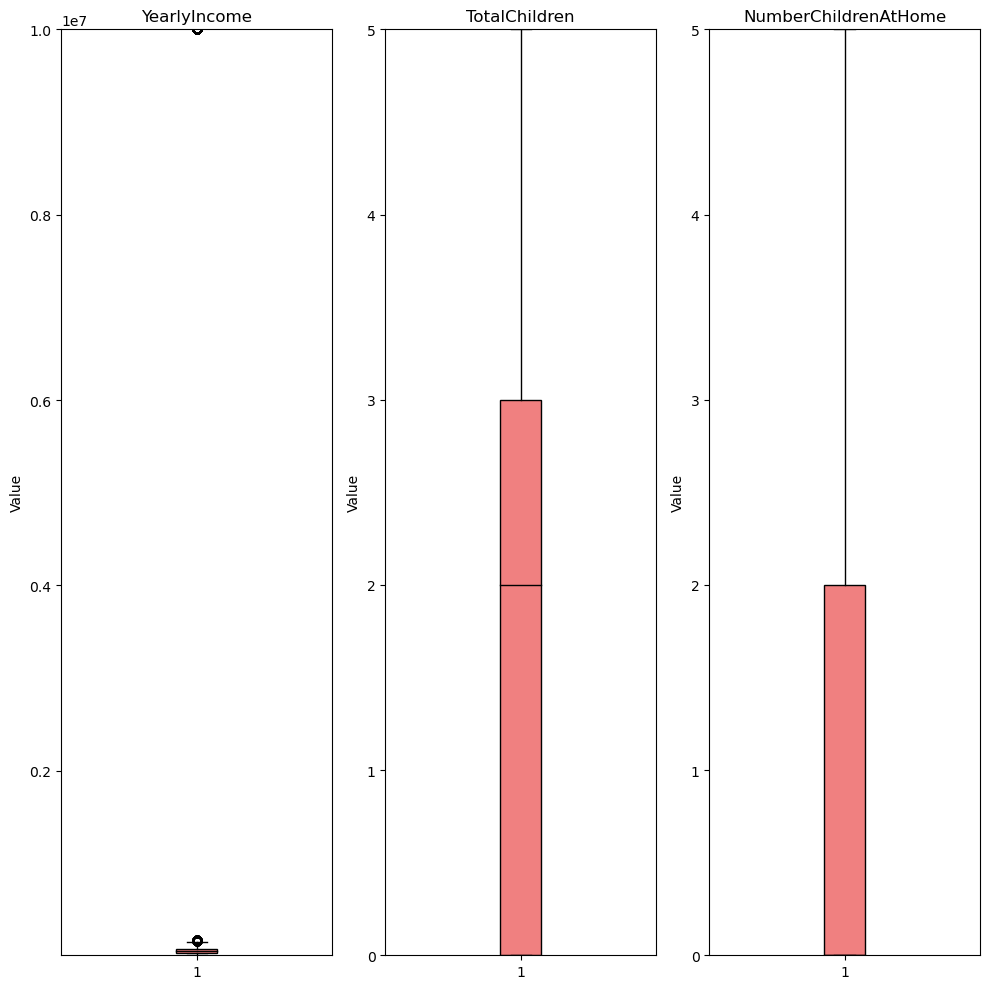

In [10]:
columns_boxplot = ['YearlyIncome', 'TotalChildren', 'NumberChildrenAtHome']
num_rows = 1
num_cols = 3
#Creating the figure and draw a 5x3-size matrix to store graphs
fig_box, axes_box = plt.subplots(num_rows, num_cols, figsize=(10,10))
#axes is a numpy.array
axes_box = axes_box.flatten() #convert to 1d array

for i, column in enumerate(columns_boxplot):
    axis = axes_box[i]
    box = axis.boxplot(customer_geo[column], patch_artist=True)
    # Fill the boxplot with color
    for patch in box['boxes']:
        patch.set_facecolor('lightcoral')  
    
    # Change colour of the median line
    for median_line in box['medians']:
        median_line.set_color('black')  # Change 'red' to any color you prefer
    axis.set_title(f"{column}")
    axis.set_ylabel('Value')
    axis.set_ylim(customer_geo[column].min(), customer_geo[column].max())

plt.tight_layout() #Preventing an axis from overlapping another axis
plt.show()

In [11]:
numeric_cols = customer_geo.select_dtypes(include=np.number).columns
#Dropping outliers using z-score
def outliers_cleaning(data: pd.DataFrame, numeric_columns: list) -> pd.DataFrame:
    for column in numeric_columns:
        upper_limit = data[column].mean() + 3*data[column].std()
        lower_limit = data[column].mean() - 3*data[column].std()
        data = data[(data[column] > lower_limit) & (data[column] < upper_limit)]
    return data

customer_geo = outliers_cleaning(customer_geo, numeric_cols)

# Data Transformation

In [12]:
customer_geo.head()

,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,Education,Occupation,ContinentName
0,M,M,90000.0,2.0,0.0,Bachelors,Professional,Asia
1,S,M,10000.0,0.0,0.0,Partial College,Manual,Asia
2,S,M,10000.0,1.0,1.0,High School,Manual,Asia
3,M,F,20000.0,0.0,0.0,Bachelors,Clerical,Asia
4,M,F,80000.0,5.0,5.0,Graduate Degree,Management,Asia


Encode "MaritalStatus" column

In [13]:
mapping_maritalstatus = {'M': 1, 'S': 0} ##1: Married, 0: Single
customer_geo['MaritalStatus'] = [mapping_maritalstatus[marital] for marital in customer_geo['MaritalStatus']]

Encode "Gender" column

In [14]:
mapping_gender = {'F': 0, 'M': 1} ##0: Female, 1: Male
customer_geo['Gender'] = [mapping_gender[sex] for sex in customer_geo['Gender']]

Encode "Education" column

In [15]:
mapping_edu = {'Partial High School': 1, 'High School': 2, 'Partial College': 3, 'Bachelors': 4, 'Graduate Degree': 5}
customer_geo['Education'] = [mapping_edu[edu] for edu in customer_geo['Education']]

Encode "Operation" column

In [16]:
onehot_occupation = pd.get_dummies(customer_geo['Occupation'], dtype=np.int64)
customer_geo = pd.concat([customer_geo, onehot_occupation], axis = 1)
#Drop 'Occupation" column
customer_geo = customer_geo.drop('Occupation', axis = 1)

Encode "GeographyType" column

In [17]:
# customer_geo['GeographyType'].unique() ##Has only 1 value, not helping for segmentation, this column will be dropped


Encode "ContinentName" column

In [18]:
onehot_continent = pd.get_dummies(customer_geo['ContinentName'], dtype=np.int64)
customer_geo = pd.concat([customer_geo, onehot_continent], axis = 1)
#Drop 'ContinentName" column
customer_geo = customer_geo.drop('ContinentName', axis = 1)

Transform "YearlyIncome"

In [19]:
##Function to transform using z-score
def transform_zscore(data: pd.DataFrame, col: str) -> pd.Series:
    mean_col = data[col].mean()
    std_col = data[col].std()
    result = [round((value - mean_col)/std_col,2) for value in data[col]]
    return result

customer_geo['YearlyIncome'] = transform_zscore(customer_geo, 'YearlyIncome')

In [20]:
customer_geo.head()

,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,Education,Clerical,Management,Manual,Professional,Skilled Manual,Asia,Europe,North America
0,1,1,1.01,2.0,0.0,4,0,0,0,1,0,1,0,0
1,0,1,-1.47,0.0,0.0,3,0,0,1,0,0,1,0,0
2,0,1,-1.47,1.0,1.0,2,0,0,1,0,0,1,0,0
3,1,0,-1.16,0.0,0.0,4,1,0,0,0,0,1,0,0
4,1,0,0.70,5.0,5.0,5,0,1,0,0,0,1,0,0


# Data Reduction

Demensionality reduction

In [21]:
pca = PCA(n_components=2)
customer_geo_pca = pca.fit_transform(customer_geo)

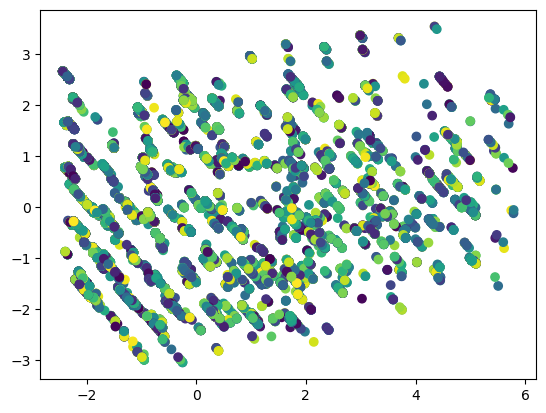

In [22]:
colors = np.random.rand(customer_geo_pca.shape[0])
plt.scatter(customer_geo_pca[:,0], customer_geo_pca[:,1], c = colors)

# BANG - clustering

In [23]:
# Prepare algorithm's parameters.
levels = 11
# Create instance of BANG algorithm.
bang_instance = bang(customer_geo_pca, levels)
bang_instance.process()


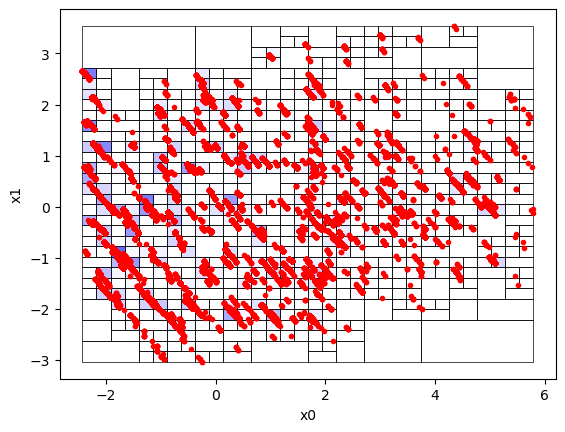

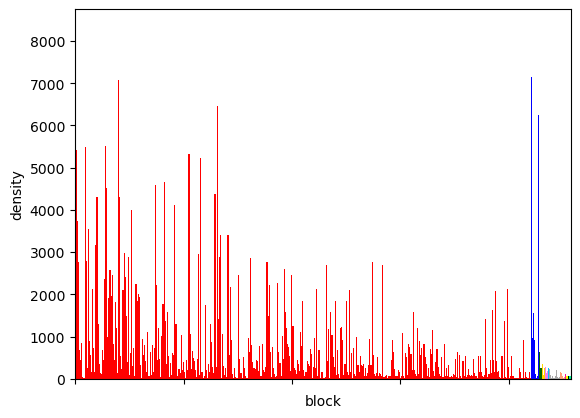

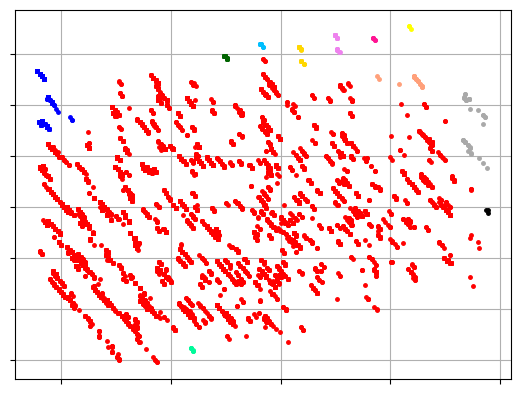

In [24]:
#Obtain clustering results.
clusters = bang_instance.get_clusters()
noise = bang_instance.get_noise()
directory = bang_instance.get_directory()
dendrogram = bang_instance.get_dendrogram()
# Visualize BANG clustering results.
bang_visualizer.show_blocks(directory)
bang_visualizer.show_dendrogram(dendrogram)
bang_visualizer.show_clusters(customer_geo_pca, clusters, noise)